In [13]:
from os import getcwd, path
from sys import path as systempath
cwd = getcwd()
systempath.append(path.join(cwd,'../'))
import numpy as np
from scipy import stats
import finite_source_point_lens_feature as feature
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy.optimize as opt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
% matplotlib inline

In [2]:
def Cauchy(x,a,b,c,d):
    """Function describing a bell curve of the form:
    f(x; a,b,c,d) = d / [1 + |(x-c)/a|^(2b)]
    
    Inputs:
    :param  np.array x: Series of intervals at which the function should
                        be evaluated
    :param float a,b,c: Coefficients of the bell curve function
    
    Returns:
    :param np.array f(x): Series of function values at the intervals in x
    """
    
    
    fx = d / ( 1.0 + (abs( (x-c)/a ))**(2.0*b) )
    
    return fx

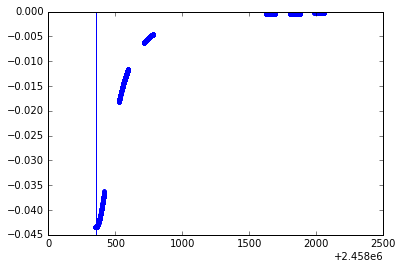

In [118]:
#Test the function and understand its parameters
plt.plot(t, Cauchy(t,10, 3, min(t)+200, 10), 'b.')
plt.xlim(min(t)+200-50,min(t)+200+50)

In [15]:
def Cauchy_fit (t, m, tE, b, t0, amp):
    
    paramt = [tE, b, t0, amp]
    
    popt, pcov = opt.curve_fit(Cauchy, t, m, p0=paramt)
    
    
    
    return popt
    
    
    

In [16]:
# Path to the larger dataset
home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'#lc/'
direc = os.listdir(temp)

In [17]:
def calc_chisq2(lightcurve,fx,ferror):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    
    chisq = ((lightcurve - fx)**2 / (ferror**2)).sum()
    
    return chisq

In [89]:
def localize_event(lightcurve,it0, dt=10):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    t0 = lightcurve[it0,0]
    
    idx1 = np.where(lightcurve[:,0] >= t0-dt)[0]
    idx2 = np.where(lightcurve[:,0] <= t0+dt)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve[:,0]),1)
    baseline = np.delete(baseline,event)
        
    return baseline, event
    
def estimate_init_param(lightcurve, it0, model, baseline,event):
    """Function to provide rough estimates of the model parameters
    prior to fitting.
    
    Model parameter indicates which order in the coefficients array
    should be used, appropriate to model = { gaussian, bellcurve }
    options.
    """
    
    a = np.median(lightcurve[baseline,1]) - lightcurve[it0,1]

    half_mag = np.median(lightcurve[baseline,1]) - (a/1.2)
    dm = abs(lightcurve[:,1] - half_mag)
    idx = dm.argsort()
    base = np.round(np.median(lightcurve[baseline,1]),4)
    
    dt = abs(lightcurve[idx[0],0] - lightcurve[idx[1],0])
    
    if model == 'gaussian':
        g_init_par = [ a, 0.0, dt ]
    
    elif model == 'Cauchy':
        g_init_par = [ dt, 1.0, lightcurve[it0,0], a]
        
    elif model == 'PSPL':
        g_init_par = [ 0.0, 0.1, dt, base]
      
        
    else:
        raise RuntimeError('Unrecognised model type '+model)
        
    return g_init_par


In [90]:
name = 'mag.dcnormffp_0_82_11.det.lc.W149'
f = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'+str(name)
t,m,e = np.loadtxt(f,unpack=True)

F = 100**((np.max(m)-m)/5)

df = pd.DataFrame({'t': t, 'Flux_Ratio': F, 'magnitude': m, 'm_err': e})

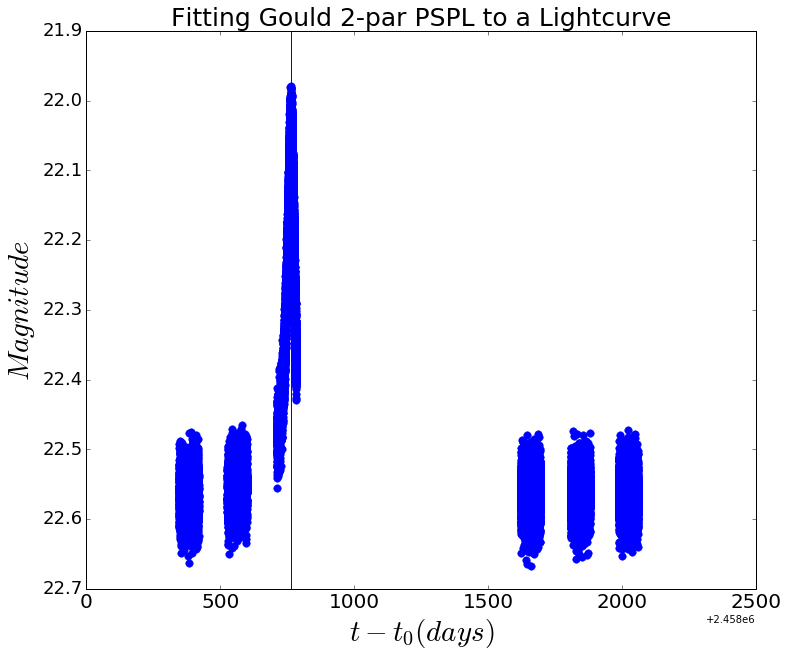

In [92]:
dtt = 30
t0 =529
t1 = t0-dtt
t2 = t0+dtt
plt.figure()
plt.title('Fitting Gould 2-par PSPL to a Lightcurve', size=25)
plt.xlabel('$t - t_0 (days)$',size=29)
plt.ylabel('$Magnitude$',size=29)
plt.tick_params(axis='y',labelsize=18)
plt.tick_params(axis='x',labelsize=20)
plt.plot(t, m, 'b.', markersize=15)
#plt.plot(t-22458234,result['solution'][i],'g-', linewidth=3)
plt.axvline(t[np.argmin(m)])
#plt.xlim(515,540)
plt.gca().invert_yaxis()
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
#fig.savefig('Trapezoid_FFP.png')

In [93]:
# t = df['t'][(df.t>t1+2458234)&(df.t<t2+2458234)].values
# m = df['magnitude'][(df.t>t1+2458234)&(df.t<t2+2458234)].values

In [111]:
it0 = np.argmin(m)
baseline, event = localize_event(lightcurve,it0, dt=50)

In [123]:
base_mag = np.median(m[baseline])
A = 10 ** (0.4*(base_mag - m))

In [125]:
lightcurve = np.zeros((len(t),3))
lightcurve[:,0] = t
lightcurve[:,1] = A
lightcurve[:,2] = e

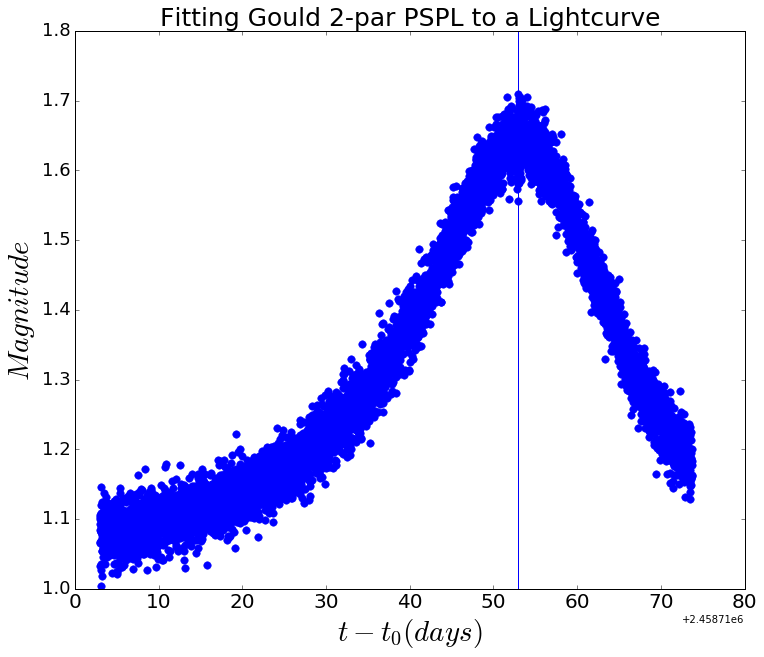

In [124]:
plt.figure()
plt.title('Fitting Gould 2-par PSPL to a Lightcurve', size=25)
plt.xlabel('$t - t_0 (days)$',size=29)
plt.ylabel('$Magnitude$',size=29)
plt.tick_params(axis='y',labelsize=18)
plt.tick_params(axis='x',labelsize=20)
plt.plot(t[event], A[event], 'b.', markersize=15)
#plt.plot(t-22458234,result['solution'][i],'g-', linewidth=3)
plt.axvline(t[it0])
#plt.xlim(515,540)
#plt.gca().invert_yaxis()
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
#fig.savefig('Trapezoid_FFP.png')

In [126]:
# estimate_init_param returns [tE, b, t0, amp]
param_ini = estimate_init_param(lightcurve, t0, 'Cauchy', baseline,event)

In [127]:
print param_ini

[22.63898199982941, 1.0, 2458352.432793, 0.03927387637274693]


In [131]:
popt = Cauchy_fit(t, m, 22.63898199982941, 1.0, 2458352.432793, 0.7)
print popt

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: overflow encountered in power


[-1.30128708e+02 -2.42060549e+00  2.45907040e+06  2.25730240e+01]


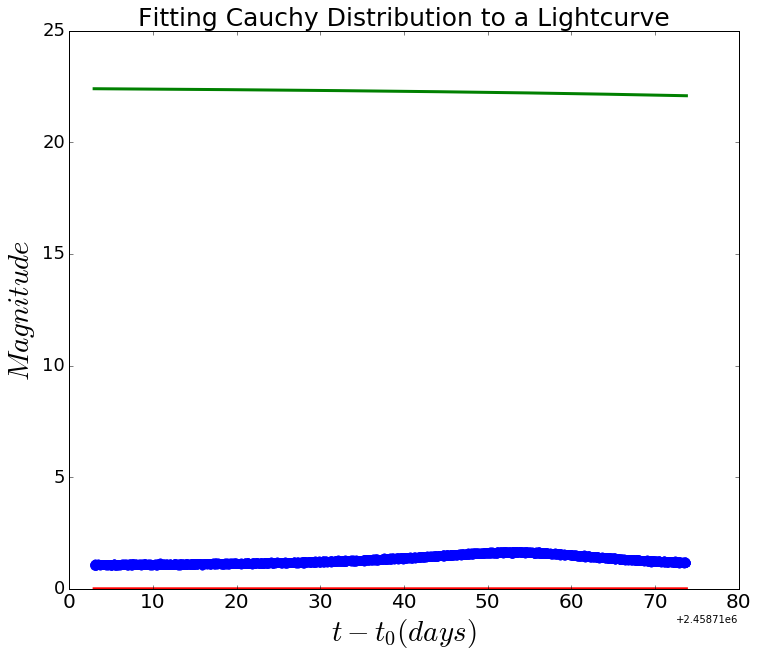

In [132]:
#t0_ini = t[np.argmin(m)] #t[np.argmax(m[m <np.percentile(m ,[0,99.95] )[1]])]
# dt = 1 #[0.01, 0.5, 2, 5, 10, 20]
# print t0_ini-2458234
# b_ini = 1.0
# amp_ini = (max(m)- min(m))
# print amp_ini



plt.figure()
plt.title('Fitting Cauchy Distribution to a Lightcurve', size=25)
plt.xlabel('$t - t_0 (days)$',size=29)
plt.ylabel('$Magnitude$',size=29)
plt.tick_params(axis='y',labelsize=18)
plt.tick_params(axis='x',labelsize=20)
plt.plot(t[event], A[event], 'b.', markersize=15)
plt.plot(t[event],Cauchy(t[event], *popt),'g-', linewidth=3)
plt.plot(t[event],Cauchy(t[event], *param_ini),'r-', linewidth=3)


#plt.axvline(t[np.argmin(m)]-2458234)
#plt.xlim(515,540)
#plt.gca().invert_yaxis()
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
#fig.savefig('Trapezoid_FFP.png')